# Прогноз одобрения кредита - на базе случайного леса

#### Цель проекта:
Демонстрация полного проекта машинного обучения с нуля до развёртывания в веб-приложении

#### Приложение на практике (в бизнесе): 
Модель, которая прогнозирует: следует одобрять кредит и автоматизирует процесс принятия заявки

#### Цель: 
Создание модели, которая точно прогнозирует надлежит ли одобрять кредит клиенту. Причём такой, которая не станет одобрять слишком много, тех кредитов, которые должны были бы быть отвергнуты (минимизация ложно-позитивных ответов)

#### Продукт:
Веб-приложение, которое пользователи могут использовать для прогноза одобрения кредитов 

    Web App: (???) - Добавить ссылку https://jessramos2-loan-approval-random-forest-web-streamlit-app-47jl27.streamlitapp.com/

#### Данные, пример дерева решений и скриншот веб-приложения в репозитории

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
import pickle
from sklearn.tree import export_graphviz
#from dtreeviz.trees import dtreeviz
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import streamlit as st
import datacompy as dc
from scipy import stats

Please note that you are missing the optional dependency: fugue. If you need to use this functionality it must be installed.
Please note that you are missing the optional dependency: snowflake. If you need to use this functionality it must be installed.
Please note that you are missing the optional dependency: spark. If you need to use this functionality it must be installed.
C:\Users\Администратор\AppData\Local\Temp\ipykernel_7084\1590025466.py:13: UserWarning: Python 3.12 and above currently is not supported by Spark and Ray. Please note that some functionality will not work and currently is not supported.
  import datacompy as dc


### Импортирем данные, анализируем описательную статистику, удаляем значения NULL

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
data.shape

(614, 13)

### Дизбаланс классов:

Результирующая переменная имеет небольшой дисбаланс. Если бы набор данных был умеренно или сильно дисбалансирован, было бы целесообразно сделать выборку с запасом для класса меньшинства или с недобором для класса большинства.

#### Возможные методы для работы с дизбалансом:
    - Случайный выбор наблюдений для перевыборки/недовыборки
    - SMOTE: синтетически создаёт новые наблюдения на основе статистики

In [5]:
# Проверяем на дизбаланс классов
data['Loan_Status'].value_counts()

Loan_Status
Y    422
N    192
Name: count, dtype: int64

### Исследовательский анализ данных (EDA)
Explore variable distributions and interactions
Изучаем распределение и взаимодействие переменных

- Гистограммы, ящики с усами, перекрёстные таблицы

In [6]:
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


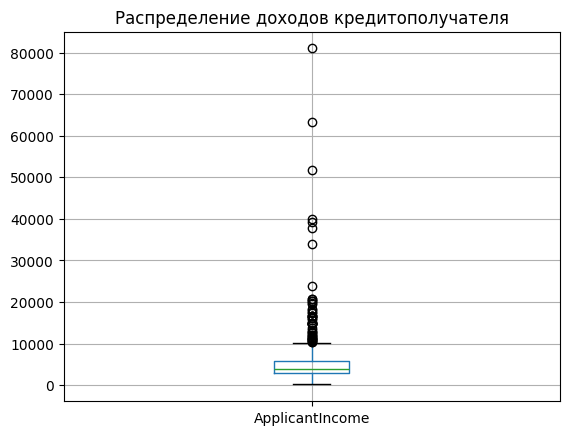

In [7]:
ApplicantIncome = data.boxplot(column = 'ApplicantIncome')
ApplicantIncome.set_title("Распределение доходов кредитополучателя")
plt.show()

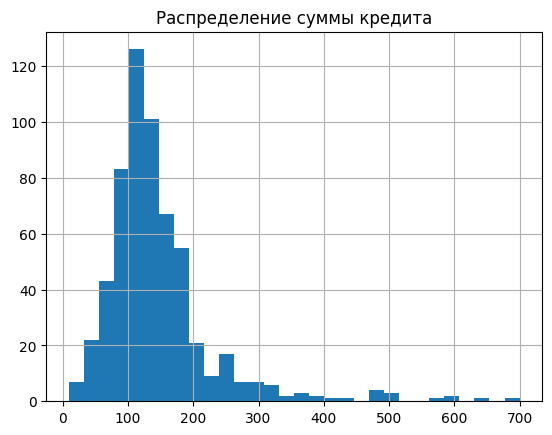

In [9]:
LoanAmount = data['LoanAmount'].hist(bins = 30)
LoanAmount.set_title("Распределение суммы кредита")
plt.show()

In [10]:
Property_Area = pd.crosstab(data['Property_Area'], data['Loan_Status'], margins = True)
Property_Area

Loan_Status,N,Y,All
Property_Area,,,
Rural,69,110,179
Semiurban,54,179,233
Urban,69,133,202
All,192,422,614


In [11]:
Married = pd.crosstab(data['Married'], data['Loan_Status'], margins = True)
Married

Loan_Status,N,Y,All
Married,,,
No,79,134,213
Yes,113,285,398
All,192,419,611


In [12]:
CreditHistory = pd.crosstab(data['Credit_History'], data['Loan_Status'], margins = True)
CreditHistory

Loan_Status,N,Y,All
Credit_History,,,
0.0,82,7,89
1.0,97,378,475
All,179,385,564


In [13]:
Gender = pd.crosstab(data['Gender'], data['Loan_Status'], margins = True)
Gender

Loan_Status,N,Y,All
Gender,,,
Female,37,75,112
Male,150,339,489
All,187,414,601


In [14]:
Self_employed = pd.crosstab(data['Self_Employed'], data['Loan_Status'], margins = True)
Self_employed

Loan_Status,N,Y,All
Self_Employed,,,
No,157,343,500
Yes,26,56,82
All,183,399,582


In [15]:
data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [16]:
data = data.dropna()

### Инжиниринг признаков: Общий доход заявителя

Для учёта одновременно и дохода заёмщика и созаёмщика (если есть таковой)

In [17]:
data['TotalApplicantIncome'] = data['ApplicantIncome'] + data['CoapplicantIncome']
data

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalApplicantIncome
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,6091.0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,3000.0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,4941.0
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,6000.0
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y,9613.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y,2900.0
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y,4106.0
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y,8312.0
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y,7583.0


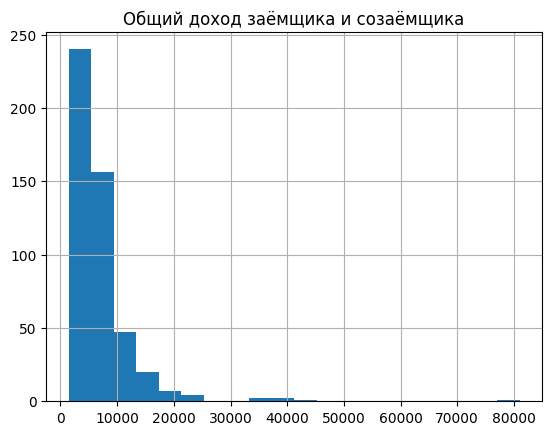

In [18]:
TotalAppInc_hist = data['TotalApplicantIncome'].hist(bins = 20)
TotalAppInc_hist.set_title("Общий доход заёмщика и созаёмщика")
plt.show()

### Создаём фиктивные переменные для подготовки к случайному лесу

In [19]:
data.astype({'Credit_History' : int})

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalApplicantIncome
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1,Rural,N,6091.0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1,Urban,Y,3000.0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1,Urban,Y,4941.0
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1,Urban,Y,6000.0
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1,Urban,Y,9613.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1,Rural,Y,2900.0
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1,Rural,Y,4106.0
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1,Urban,Y,8312.0
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1,Urban,Y,7583.0


In [20]:
### Создаём фиктивные переменные для подготовки к случайному лесу

data = pd.get_dummies(data, columns = ['Gender'], drop_first = True)
data

data = pd.get_dummies(data, columns = ['Married'], drop_first = True)
data

data = pd.get_dummies(data, columns = ['Loan_Status'], drop_first = True)
data = data.rename(columns = {'Loan_Status_Y' : 'Loan_Approved'})
data

,Loan_ID,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,TotalApplicantIncome,Gender_Male,Married_Yes,Loan_Approved
1,LP001003,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,6091.0,True,True,False
2,LP001005,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,3000.0,True,True,True
3,LP001006,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,4941.0,True,True,True
4,LP001008,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,6000.0,True,False,True
5,LP001011,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,9613.0,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,2900.0,False,False,True
610,LP002979,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,4106.0,True,True,True
611,LP002983,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,8312.0,True,True,True
612,LP002984,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,7583.0,True,True,True


In [21]:
data.astype({'Credit_History' : int})

,Loan_ID,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,TotalApplicantIncome,Gender_Male,Married_Yes,Loan_Approved
1,LP001003,1,Graduate,No,4583,1508.0,128.0,360.0,1,Rural,6091.0,True,True,False
2,LP001005,0,Graduate,Yes,3000,0.0,66.0,360.0,1,Urban,3000.0,True,True,True
3,LP001006,0,Not Graduate,No,2583,2358.0,120.0,360.0,1,Urban,4941.0,True,True,True
4,LP001008,0,Graduate,No,6000,0.0,141.0,360.0,1,Urban,6000.0,True,False,True
5,LP001011,2,Graduate,Yes,5417,4196.0,267.0,360.0,1,Urban,9613.0,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,0,Graduate,No,2900,0.0,71.0,360.0,1,Rural,2900.0,False,False,True
610,LP002979,3+,Graduate,No,4106,0.0,40.0,180.0,1,Rural,4106.0,True,True,True
611,LP002983,1,Graduate,No,8072,240.0,253.0,360.0,1,Urban,8312.0,True,True,True
612,LP002984,2,Graduate,No,7583,0.0,187.0,360.0,1,Urban,7583.0,True,True,True


### Модель случайного леса: 
-Делим данные на набор для обучения и тестирования(80% & 20%)

-Лес из 100 деревьев

-Минимум 5 объектов в листе - что бы предотвратить излишнюю фрагментацию дерева

-Максимальная глубина 4: 
    - Глубина больше 4 не улучшала модель и не повышала её предсказательную способность
    - Глубина 4 помогает избежать переобучения
    
#### Объясняемая/Зависимая перменная (Y): 
Loan_Approved
#### Независимые перменные: 
Gender, Married, TotalApplicantIncome, LoanAmount, Credit_History

In [22]:
# независимые переменные
features = ['Gender_Male', 'Married_Yes', 'TotalApplicantIncome', 'LoanAmount', 'Credit_History']
X = data[features]
# зависимые перменные
dependent = 'Loan_Approved'
y = data[dependent]
X.shape, y.shape

# Разделить набор данных на обучающую выборку (80%) и тестовую выборку (20%), перемешав наблюдения.
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 10, shuffle = True)

# Построить модель случайного леса, ограничив максимальную глубину деревьев для предотвращения переобучения.
forest = RandomForestClassifier(max_depth=4, random_state = 10, n_estimators = 100, min_samples_leaf=5) 
model = forest.fit(x_train, y_train)
model

RandomForestClassifier(max_depth=4, min_samples_leaf=5, random_state=10)

### Важность признаков: 

Credit_History - самый важный признак для прогнозирования одобрения кредита, за ним следует общий ход заявителя

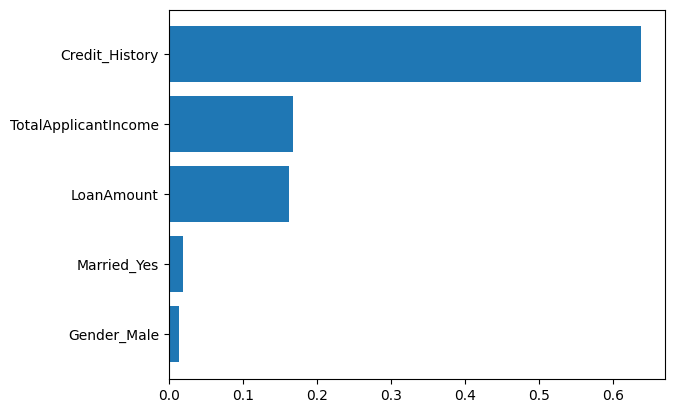

In [23]:
feature_importance = list(zip(features,forest.feature_importances_))
feature_importance.sort(key = lambda x : x[1])
plt.barh([x[0] for x in feature_importance],[x[1] for x in feature_importance])
plt.show()

## Дерево решений из случайного леса

— Пример дерева см. в репозитории на GitHub (.png)

— Индекс Джини: показывает объясняющую способность переменной; равен 0, когда все образцы принадлежат одному классу (наилучший показатель чистоты узла и прироста информации)

— Класс: показывает предсказанный класс (0 = не одобрено, 1 = одобрено)

In [24]:
estimator = model.estimators_[50]
estimator
model.estimators_[50].tree_.max_depth

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (32,20), dpi=500)
sk.tree.plot_tree(estimator, filled=True, fontsize = 10, feature_names=features, class_names = True)
fig.savefig('DecisionTree.png')

## Accuracy, Precision, Recall, & F1 Score

#### Accuracy 

= (TP + TN) / (TP + TN + FP + FN) = TruePositives&Negatives / All 

Какой % значений, которые были корректно предсказаны?


#### Precision 

= TP / (TP + FP) = TruePositive / PredictedPositives

Какой процент предсказанных положительных случаев действительно являются положительными?

#### Recall 

= TP / (TP + FN) = TruePositive / ActualPositives

Какой процент реально положительных случаев был правильно предсказан как положительный?

#### F1 Score

= 2 * (Precision * Recall) / (Precision + Recall)

Балансировка Precision и Recall (взвешенное среднее), полезно для данных с классовым имбалансом учитывает как ложные положительные, так и ложные отрицательные результаты.

In [25]:
# Предсказанные значения Y (результаты) для тестовых и обучающих наблюдений
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

# Accuracy
accuracy_train = accuracy_score(y_train,pred_train)
accuracy_test = accuracy_score(y_test,pred_test)


# Precision
precision_train = sk.metrics.precision_score(y_train,pred_train)
precision_test = sk.metrics.precision_score(y_test,pred_test)

# Recall
recall_train = sk.metrics.recall_score(y_train,pred_train)
recall_test = sk.metrics.recall_score(y_test,pred_test)

# F1
f1_train = (2 * precision_train * recall_train) / (precision_train + recall_train)
f1_test = (2 * precision_test * recall_test) / (precision_test + recall_test)


print('Accuracy обучение:',accuracy_train,'Accuracy тестирование:',accuracy_test)
print('Precision обучение:',precision_train,'Precision тестирование:',precision_test)
print('Recall обучение:',recall_train,'Recall тестирование:',recall_test)
print('F1 обучение:',f1_train,'F1 тестирование:',f1_test)

Accuracy обучение: 0.8098958333333334 Accuracy тестирование: 0.8020833333333334
Precision обучение: 0.7962962962962963 Precision тестирование: 0.7790697674418605
Recall обучение: 0.9735849056603774 Recall тестирование: 1.0
F1 обучение: 0.8760611205432938 F1 тестирование: 0.8758169934640523


In [26]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

       False       1.00      0.34      0.51        29
        True       0.78      1.00      0.88        67

    accuracy                           0.80        96
   macro avg       0.89      0.67      0.69        96
weighted avg       0.85      0.80      0.77        96



Precision = TP/(TP+FP)

​Recall = TP/TP+FN

F1-score = 2*Precision⋅Recall/(Precision+Recall)

Support - сколько раз данный класс встречался в истинных метках (y_true)

## Бизнес-контекст и оценка модели

С бизнес-точки зрения мы хотим избегать ситуаций, когда модель предсказывает одобрение кредита, хотя на самом деле он был отклонён (ложные положительные срабатывания — False Positives). Поэтому Точность (Precision) будет нашей основной метрикой оценки модели. Это гарантирует, что мы точно предсказываем одобрения и что все заявки, помеченные как «одобрены», действительно были одобрены на практике.

Поскольку эта модель демонстрирует очень схожие значения точности (precision) как на обучающих, так и на тестовых данных, она, по-видимому, является наилучшим вариантом — обеспечивает максимальную предсказательную способность на обучающей выборке без переобучения и без потери качества предсказаний на тестовой выборке. 

**Precision:** 
В нашем случае Precision ~78% на тестируемых данных, что значит, что у нас нет большого числа ложных позитивов. Это отлично, потому что с точки зрения бизнеса мы хотим избегать предсказаний одобрения кредитов, которые впоследствии придётся отклонять

**Accuracy:**
Точность на тестовых данных составляет около 80%, что означает, что модель правильно предсказывает 4 из 5 кредитов.

**Recall:**
Полнота (Recall) на тестовых данных составляет 100%, что означает, что модель корректно предсказывает все истинно положительные случаи. Это значит, что мы не упустим ни одного потенциального одобрения кредита (а значит, и не потеряем связанную с ним выручку)

**F1 Score:**
Значение F1-меры на тестовых данных составляет около 88%, что является отличным результатом, поскольку эта метрика учитывает как ложные положительные, так и ложные отрицательные срабатывания.



## Признаки переобучения и недообучения: 

#### Переобучение: 
- Слишком сильно зависит от обучающих данных. Показывает отличные результаты на обучающей выборке, но производительность снижается на тестовой выборке.
- Необходимо уменьшить сложность модели и удалить из неё лишние слои и признаки.


#### Недообучение: 
- Неспособность выявить зависимости в обучающих данных, низкая производительность на обучающей выборке
- Потребность в увеличении комплексности модели и добавления уровней и признаков к ней же

#### Наша модель не показывает признаков недообучения и переобучения

In [27]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

       False       1.00      0.34      0.51        29
        True       0.78      1.00      0.88        67

    accuracy                           0.80        96
   macro avg       0.89      0.67      0.69        96
weighted avg       0.85      0.80      0.77        96



## Матрица ошибок

- Определяет истинно положительные, истинно отрицательные, ложно положительные и ложно отрицательные результаты на основе предсказанных и фактических значений в следующем формате:

|         |Предсказанные негативы|Предсказанные позитивы|
|----               |----    |----    |
|**Настоящие негативы**|**TN**  | FP     |
|**Настоящие позитивы**| FN     |**TP**  |


                                        FP - это I тип ошибки, FN - это II тип ошибки

In [28]:
confusion_matrix = confusion_matrix(y_test, pred_test)
confusion_matrix

array([[10, 19],
       [ 0, 67]])

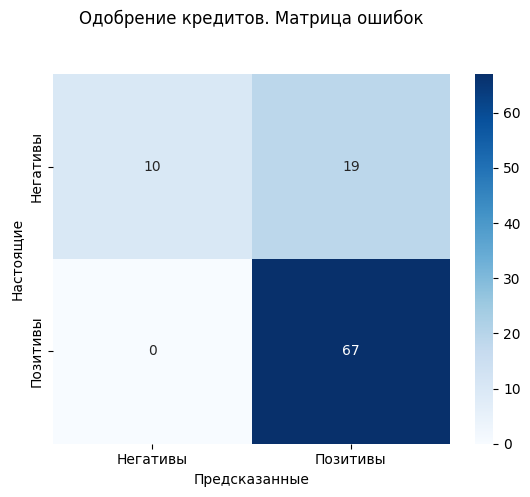

In [30]:
ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt = '')

ax.set_title('Одобрение кредитов. Матрица ошибок\n\n')
ax.set_xlabel('Предсказанные')
ax.set_ylabel('Настоящие')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Негативы','Позитивы'])
ax.yaxis.set_ticklabels(['Негативы','Позитивы'])

## Display the visualization of the Confusion Matrix.
plt.show()

 #### Тестирование предсказаний модели на новых входных данных для подготовки к веб-приложению

In [30]:
inputs = [[1, 1, 0, 71, 0]]

pred_inputs = model.predict(inputs)
pred_inputs[0]

c:\Users\Администратор\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


np.False_

#### Следующий шаг: используйте файл pickle для передачи модели в код веб-приложения на Python

In [31]:
pickle_out = open("Loan_Approval_Prediction.pkl", mode = "wb") 
pickle.dump(model, pickle_out) 
pickle_out.close()